In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-04-20 10:56:28.778455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading

In [2]:
X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

## Neural Netwrok

### Common Target

In [15]:
def r2_score(y_true, y_pred):
    ss_total = K.sum(K.square(y_true - K.mean(y_true)))
    ss_res = K.sum(K.square(y_true - y_pred))
    return (1 - ss_res / (ss_total + K.epsilon()))


In [16]:
# def r2_score_target_1(y_true, y_pred):
#     ss_total = K.sum(K.square(y_true[:, 0] - K.mean(y_true[:, 0])))
#     ss_res = K.sum(K.square(y_true[:, 0] - y_pred[:, 0]))
#     return (1 - ss_res / (ss_total + K.epsilon()))

# def r2_score_target_2(y_true, y_pred):
#     ss_total = K.sum(K.square(y_true[:, 1] - K.mean(y_true[:, 1])))
#     ss_res = K.sum(K.square(y_true[:, 1] - y_pred[:, 1]))
#     return (1 - ss_res / (ss_total + K.epsilon()))


In [17]:
# def loss_motor_updrs(y_true, y_pred):
#     return K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))

# def loss_total_updrs(y_true, y_pred):
#     return K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))


In [18]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='linear') )  # 2 outputs: motor_UPDRS and total_UPDRS

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [20]:
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss={'motor_total_output': 'mean_squared_error'},  # Use 'mean_squared_error' as total loss
#               metrics={'motor_total_output': ['mean_squared_error', r2_score_target_1, r2_score_target_2]})  # Specify metrics


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [22]:
history = model.fit(X_train_scaled, y_train_common, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_common),
                    callbacks=[lr_scheduler, early_stopping], verbose=1)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 763.5529 - r2_score: -7.1301 - val_loss: 478.7986 - val_r2_score: -23.0107 - learning_rate: 0.0010
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 585.5204 - r2_score: -4.9757 - val_loss: 274.6802 - val_r2_score: -10.5561 - learning_rate: 0.0010
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 280.3951 - r2_score: -1.8904 - val_loss: 109.2491 - val_r2_score: -2.7626 - learning_rate: 0.0010
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 93.1519 - r2_score: 0.0198 - val_loss: 101.7286 - val_r2_score: -6.3538 - learning_rate: 0.0010
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 49.1161 - r2_score: 0.4812 - val_loss: 127.6220 - val_r2_score: -6.9217 - learning_rate: 0.0010
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 43.1773 - r2_score: 0.5450 - val_loss: 124.5830 - val_r2_score: -6.8339 - learning_rate: 0.0010
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

In [23]:
test_loss = model.evaluate(X_test_scaled, y_test_common)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99.3488 - r2_score: -6.4034 


In [24]:
# import matplotlib.pyplot as plt
# from matplotlib import rcParams

# # Set figure size for the plots
# rcParams['figure.figsize'] = 14, 10

# # Create a 3x2 grid of subplots
# fig, ax = plt.subplots(3, 2)

# # Plot Model Loss (Overall)
# ax[0, 0].plot(history.history['loss'], 'g', label='Train Loss')
# ax[0, 0].plot(history.history['val_loss'], 'r', label='Validation Loss')
# ax[0, 0].set_title('Model Loss (Overall)')
# ax[0, 0].set_ylabel('Loss')
# ax[0, 0].set_xlabel('Epochs')
# ax[0, 0].legend(loc='upper right')
# ax[0, 0].grid(True)

# # Plot Model R² (Overall)
# ax[0, 1].plot(history.history['r2_score'], 'g', label='Train R²')
# ax[0, 1].plot(history.history['val_r2_score'], 'r', label='Validation R²')
# ax[0, 1].set_title('Model R² (Overall)')
# ax[0, 1].set_ylabel('R²')
# ax[0, 1].set_xlabel('Epochs')
# ax[0, 1].legend(loc='lower right')
# ax[0, 1].grid(True)

# # Plot Loss for motor_UPDRS (target 1)
# ax[1, 0].plot(history.history['loss_motor_updrs'], 'g', label='Train Loss')
# ax[1, 0].plot(history.history['val_loss_motor_updrs'], 'r', label='Validation Loss')
# ax[1, 0].set_title('Model Loss (motor_UPDRS)')
# ax[1, 0].set_ylabel('Loss')
# ax[1, 0].set_xlabel('Epochs')
# ax[1, 0].legend(loc='upper right')
# ax[1, 0].grid(True)

# # Plot R² for motor_UPDRS (target 1)
# ax[1, 1].plot(history.history['r2_score_target_1'], 'g', label='Train R²')
# ax[1, 1].plot(history.history['val_r2_score_target_1'], 'r', label='Validation R²')
# ax[1, 1].set_title('Model R² (motor_UPDRS)')
# ax[1, 1].set_ylabel('R²')
# ax[1, 1].set_xlabel('Epochs')
# ax[1, 1].legend(loc='lower right')
# ax[1, 1].grid(True)

# # Plot Loss for total_UPDRS (target 2)
# ax[2, 0].plot(history.history['loss_total_updrs'], 'g', label='Train Loss')
# ax[2, 0].plot(history.history['val_loss_total_updrs'], 'r', label='Validation Loss')
# ax[2, 0].set_title('Model Loss (total_UPDRS)')
# ax[2, 0].set_ylabel('Loss')
# ax[2, 0].set_xlabel('Epochs')
# ax[2, 0].legend(loc='upper right')
# ax[2, 0].grid(True)

# # Plot R² for total_UPDRS (target 2)
# ax[2, 1].plot(history.history['r2_score_target_2'], 'g', label='Train R²')
# ax[2, 1].plot(history.history['val_r2_score_target_2'], 'r', label='Validation R²')
# ax[2, 1].set_title('Model R² (total_UPDRS)')
# ax[2, 1].set_ylabel('R²')
# ax[2, 1].set_xlabel('Epochs')
# ax[2, 1].legend(loc='lower right')
# ax[2, 1].grid(True)

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()


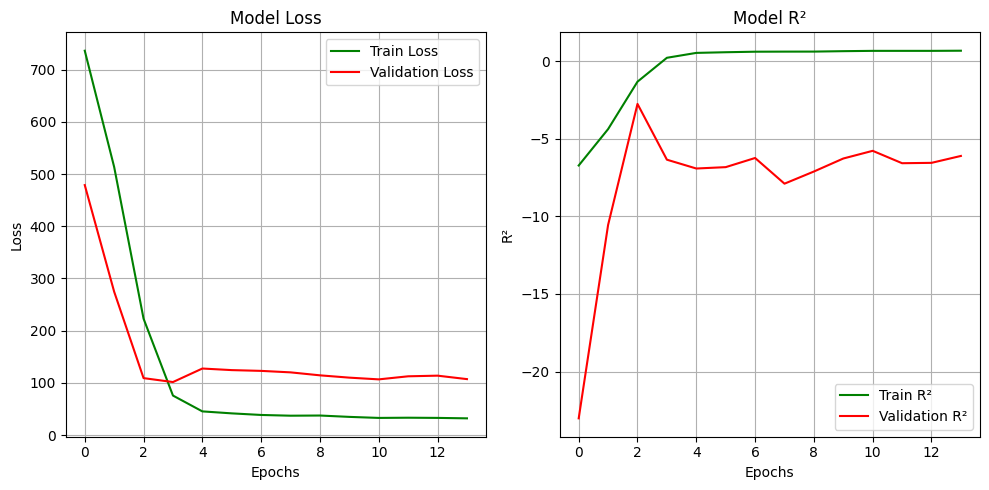

In [25]:
rcParams['figure.figsize'] = 10, 5

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['loss'], 'g', label='Train Loss')
ax[0].plot(history.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)

ax[1].plot(history.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

**NOT GOOD**

In [26]:
# predictions = model.predict(X_test_scaled)

### Seperate Targets

#### motor_UPDRS

In [31]:
motor_model = Sequential()
motor_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(128, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dropout(0.3))
motor_model.add(Dense(64, activation='relu'))
motor_model.add(BatchNormalization())
motor_model.add(Dense(1, activation='linear')) 

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
motor_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [35]:
early_stopping_motor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_motor = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


In [36]:
history_motor = motor_model.fit(X_train_scaled, y_train_motor, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_motor),
                    callbacks=[lr_scheduler_motor, early_stopping_motor], verbose=1)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 527.6313 - r2_score: -8.3430 - val_loss: 384.2693 - val_r2_score: -172.9570 - learning_rate: 0.0010
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 376.1406 - r2_score: -5.7265 - val_loss: 160.3407 - val_r2_score: -40.8948 - learning_rate: 0.0010
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 150.7102 - r2_score: -1.6046 - val_loss: 66.9635 - val_r2_score: -12.2655 - learning_rate: 0.0010
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 46.6997 - r2_score: 0.1757 - val_loss: 57.5312 - val_r2_score: -19.0332 - learning_rate: 0.0010
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 31.6243 - r2_score: 0.4516 - val_loss: 64.2288 - val_r2_score: -25.3087 - learning_rate: 0.0010
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.1031 - r2_score: 0.5017 - val_loss: 78.6733 - val_r2_score: -50.3660 - learning_rate: 0.0010
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/

In [37]:
motor_test_loss = motor_model.evaluate(X_test_scaled, y_test_motor)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.6096 - r2_score: -21.6084


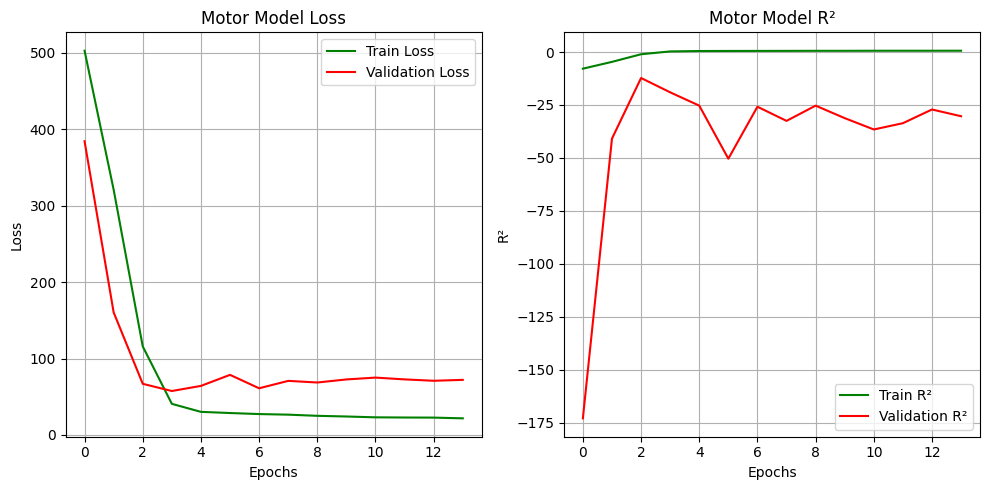

In [38]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_motor.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_motor.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Motor Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_motor.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_motor.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Motor Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

**NOT GOOD**

#### total_UPDRS

In [39]:
total_model = Sequential()
total_model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(128, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dropout(0.3))
total_model.add(Dense(64, activation='relu'))
total_model.add(BatchNormalization())
total_model.add(Dense(1, activation='linear'))

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
total_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[r2_score])

In [41]:
early_stopping_total = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler_total = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [42]:
history_total = total_model.fit(X_train_scaled, y_train_total, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test_total),
                    callbacks=[lr_scheduler_total, early_stopping_total], verbose=1)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 990.7743 - r2_score: -8.9611 - val_loss: 631.6088 - val_r2_score: -148.9571 - learning_rate: 0.0010
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 772.0697 - r2_score: -6.7345 - val_loss: 294.6894 - val_r2_score: -47.2148 - learning_rate: 0.0010
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 392.6021 - r2_score: -3.0005 - val_loss: 118.1910 - val_r2_score: -13.6194 - learning_rate: 0.0010
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 137.1081 - r2_score: -0.3336 - val_loss: 113.5573 - val_r2_score: -28.1555 - learning_rate: 0.0010
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69.6427 - r2_score: 0.2853 - val_loss: 142.1623 - val_r2_score: -41.8530 - learning_rate: 0.0010
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 53.3440 - r2_score: 0.4626 - val_loss: 181.7607 - val_r2_score: -98.2101 - learning_rate: 0.0010
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1

In [43]:
total_test_loss = total_model.evaluate(X_test_scaled, y_test_total)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103.3256 - r2_score: -27.4197


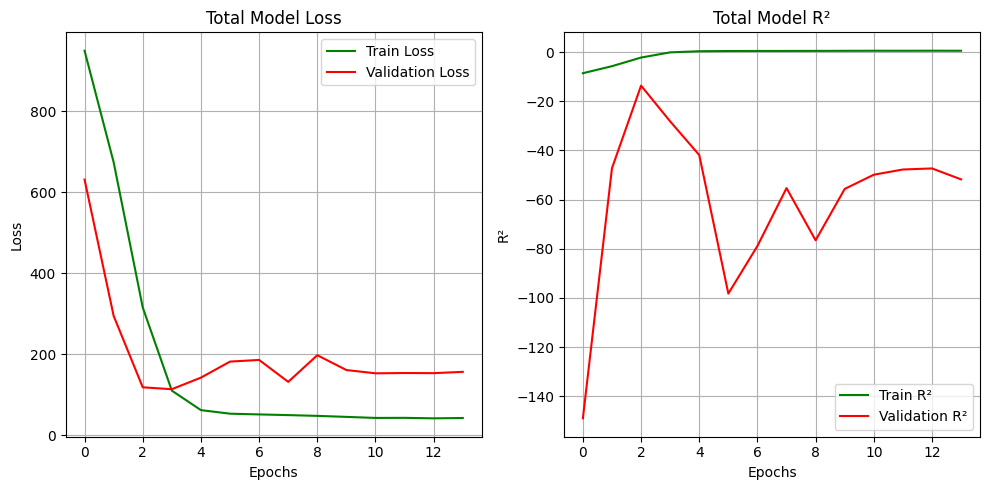

In [44]:
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(history_total.history['loss'], 'g', label='Train Loss')
ax[0].plot(history_total.history['val_loss'], 'r', label='Validation Loss')
ax[0].set_title('Total Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[1].plot(history_total.history['r2_score'], 'g', label='Train R²')
ax[1].plot(history_total.history['val_r2_score'], 'r', label='Validation R²')
ax[1].set_title('Total Model R²')
ax[1].set_ylabel('R²')
ax[1].set_xlabel('Epochs')
ax[1].legend(loc='lower right')
ax[1].grid(True)
plt.tight_layout()
plt.show()

**NOT GOOD**